<a href="https://colab.research.google.com/github/praneethmarsakatla/Restaurant_Reviews-using-Sentiment-Analysis/blob/main/Copy_of_sentiment_model_pkl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Restaurant_review/Restaurant_Reviews (1).tsv'
data = pd.read_csv(file_path, delimiter='\t')

# Display the first few rows to ensure it's loaded correctly
print(data.head())


                                              Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1


In [ ]:
import random

def generate_synthetic_reviews(original_reviews, num_new_reviews):
    synthetic_reviews = []
    for _ in range(num_new_reviews):
        # Randomly select an existing review
        review, liked = original_reviews.sample(1).iloc[0]

        # Slightly modify the review to create a synthetic one
        words = review.split()
        if len(words) > 1:
            random_word = random.choice(words)
            new_word = ''.join(random.choices(random_word, k=len(random_word)))
            words[words.index(random_word)] = new_word
            synthetic_review = ' '.join(words)
        else:
            synthetic_review = review

        synthetic_reviews.append([synthetic_review, liked])
    return pd.DataFrame(synthetic_reviews, columns=['Review', 'Liked'])


In [ ]:
# Calculate how many new reviews are needed
current_size = data.shape[0]
num_new_reviews = 3000 - current_size

# Generate synthetic reviews
synthetic_data = generate_synthetic_reviews(data, num_new_reviews)

# Combine the original dataset with the synthetic reviews
augmented_data = pd.concat([data, synthetic_data], ignore_index=True)

# Display the size of the new dataset to ensure it's correct
print(augmented_data.shape)


(3000, 2)


In [ ]:
# Save the augmented dataset to a new file
augmented_file_path = '/content/drive/MyDrive/Restaurant_review/Augmented_Restaurant_Reviews.tsv'
augmented_data.to_csv(augmented_file_path, sep='\t', index=False)


In [ ]:
import re
import string
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter

# Data visulization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


# NLP tools
import nltk
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Restaurant_review/Augmented_Restaurant_Reviews.tsv',delimiter='\t',quoting=3) #encoding="latin"
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [ ]:
data.tail()

,Review,Liked
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0
999,"Then, as if I hadn't wasted enough of my life ...",0


In [ ]:
data.shape

(3000, 2)

In [ ]:
data['Liked'] = data['Liked'].map({0:'Negative',1:'Positive'})

In [ ]:
data.describe().T

,count,unique,top,freq
Review,3000,2809,"In the summer, you can dine in a charming outd...",4
Liked,3000,2,Positive,1537


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  3000 non-null   object
 1   Liked   3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [ ]:
data.columns

Index(['Review', 'Liked'], dtype='object')

In [ ]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" ,"'ll":"will","'d":"would"}

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
'not' in stop_words

False

In [ ]:
print('Original :',data.Review.iloc[1])
print('processed with not removing negation :',' '.join([word for word in data.Review.iloc[1].split() if word not in stop_words]))

Original : Crust is not good.
processed with not removing negation : Crust not good.


In [ ]:
def text_preprocessing(text,lemmatize=False):
    '''input    : the text you want to process.
       output   : the processed text '''

    # Remove html tags
    text = BeautifulSoup(text, 'html.parser')
    text = text.get_text()
    # Lowercasing
    text = text.lower()
    # Removal of special characters, URLs, and mentions
    text = re.sub(r'http\S+|www\S+|https\S+|@[^\s]+', '', text)
    # remove more than one space with one space
    text = re.sub(r'\s+',' ',text)
    # remove more than one dot by one dot
    text = re.sub(r'\.{2,}', '.', text)
    #remove numbers with no space
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Remove punctuation,stopwords and handling the txt with (mapping dictionary) *predefiend above*
    words = [mapping[word] if word in mapping else word for word in words]
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stop_words]

    # optionally lemmatize
    if lemmatize:
        words = [nlp(word)[0].lemma_ for word in words]

    return ' '.join(words)


In [ ]:
# Function performance experiment
print('Original :',data.Review.iloc[0])
print()
print('Porcessed text :',text_preprocessing(data.Review.iloc[0],lemmatize=True))

Original : Wow... Loved this place.

Porcessed text : wow love place


In [ ]:
data['Processed_text'] = data['Review'].apply(lambda x : text_preprocessing(str(x),lemmatize=True))

In [ ]:
data.head(10)


,Review,Liked,Processed_text
0,Wow... Loved this place.,Positive,wow love place
1,Crust is not good.,Negative,crust not good
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty
3,Stopped by during the late May bank holiday of...,Positive,stop late may bank holiday rick steve recommen...
4,The selection on the menu was great and so wer...,Positive,selection menu great price
5,Now I am getting angry and I want my damn pho.,Negative,get angry want damn pho
6,Honeslty it didn't taste THAT fresh.),Negative,honeslty not taste fresh
7,The potatoes were like rubber and you could te...,Negative,potato like rubber could tell make ahead time ...
8,The fries were great too.,Positive,fry great
9,A great touch.,Positive,great touch


In [ ]:
data.nunique()

Review            2809
Liked                2
Processed_text    2786
dtype: int64

In [ ]:
data.duplicated().sum()

191

In [ ]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [ ]:
def generate_wordcloud(text,bg_color,title ='word cloud'):
    '''
    input : Text ,Back-ground color and Title
    output : Word cloud of most common words with your preferd title and back-ground color
    '''
    wordcloud =WordCloud(background_color=str(bg_color),stopwords=set(stopwords.words('english'))).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(str(title))
    plt.axis("off")
    plt.show()

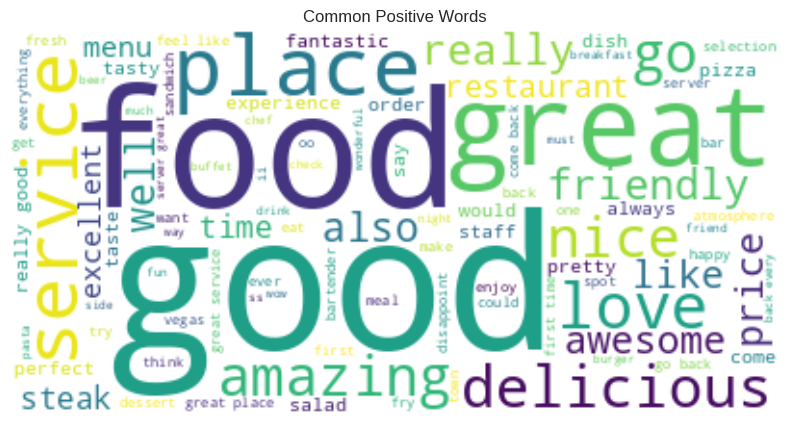

In [ ]:
generate_wordcloud(" ".join(data[data['Liked']=='Positive']['Processed_text']),bg_color='white',title='Common Positive Words')

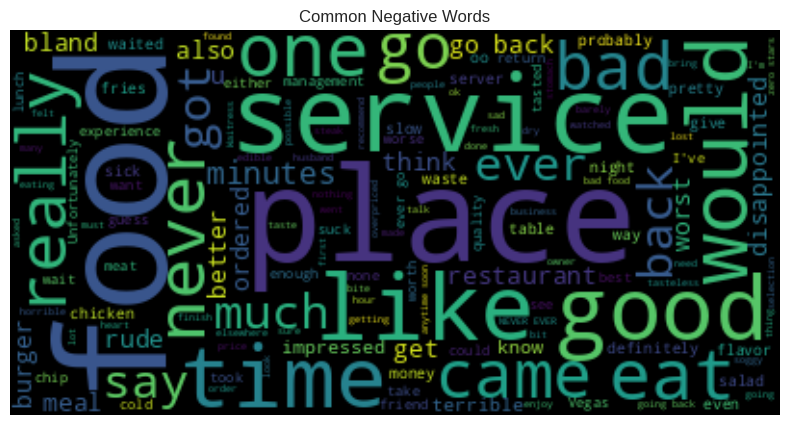

In [ ]:
generate_wordcloud(" ".join(data[data['Liked']=='Negative']['Review']),bg_color='black',title='Common Negative Words')

In [ ]:
fig = make_subplots(rows=1, cols=2,specs=[[{'type':'xy'}, {'type':'domain'}]])

fig.add_trace(
    go.Bar(
        x=data['Liked'].value_counts().index,
        y= data['Liked'].value_counts().values,
         marker=dict(color=['#6B816C','#91B092']), showlegend=False,
           text=data['Liked'].value_counts().values, textposition='auto', textfont=dict(size=18)
        ),
    row=1,col=1
    )

fig.add_trace(
    go.Pie(
        labels=data['Liked'].value_counts().index,
        values=data['Liked'].value_counts().values,
         marker=dict(colors=['#6B816C','#91B092']), textfont=dict(size=18),
         pull=[0.01,0.01]
        ),
    row=1,col=2
    )





fig.update_layout(title='<b>Distribution of the target<b>',
                 title_font={'size':25},
                 paper_bgcolor='#E0E1CD',
                 plot_bgcolor='#E0E1CD',
                 showlegend=True)

fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
def plot_commmon_words(data,title):

    '''
    input : Your data and title.
    output : plotting the top 20 common words in the input data with title you want to put on the figure.
    '''
    # put all words in one list
    corpus =[]
    for row in data:
        corpus.extend(row.split())
    # get the most common words (top 20)
    most_common_words = Counter(corpus)
    most_common_words = most_common_words.most_common(20)
    # creat the data frame of most common words (top 20)
    tem_df = pd.DataFrame(most_common_words,columns=['word','Repetition'])
    # creat the figure
    fig = px.bar(tem_df, x="Repetition", y="word", orientation='h',
             color='word')

    fig.update_layout(title=f'<b>{title}<b>',
                 title_font={'size':25},
                 paper_bgcolor='#E0E1CD',
                 plot_bgcolor='#E0E1CD',
                 showlegend=True)

    fig.update_yaxes(showgrid=False)
    fig.update_xaxes(showgrid=False)
    fig.show()



In [ ]:
plot_commmon_words(data[data['Liked']=='Positive']['Processed_text'],title='Most common words in positive reviews')

In [ ]:
plot_commmon_words(data[data['Liked']=='Negative']['Processed_text'],title='Most common words in negative reviews')

In [ ]:
plot_commmon_words(data['Processed_text'],title='Most common words in all reviews')

In [ ]:
def plot_most_freq_ngrams(text,n,title):
    '''
    input : the text or data,n-grame range and title of the figure.
    output : plotting the most common ngrams as you want
    '''

    #initialize bag of words and fitting the data
    vectorizer = CountVectorizer(ngram_range=(n,n),stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(text)
    # make a summation of all reapeted ngrams
    feature_counts = X.sum(axis=0)
    # get feature name
    feature_names = vectorizer.get_feature_names_out()
    # prepre df and make sorting to get most common ngrams
    df = pd.DataFrame({'Feature': feature_names, 'Count': feature_counts.tolist()[0]})
    df = df.sort_values(by='Count',ascending=False).head(20).reset_index(drop=True)
    # plotting the figure
    fig = px.bar(df, x="Count", y="Feature" ,orientation='h',
             color='Feature')

    fig.update_layout(title=f'<b>{title}<b>',
                 title_font={'size':25},
                 paper_bgcolor='#E0E1CD',
                 plot_bgcolor='#E0E1CD',
                 showlegend=True)

    fig.update_xaxes(showgrid=False)
    fig.show()

In [ ]:
plot_most_freq_ngrams(data['Processed_text'],n=1,title='most common unigrams to all data')

In [ ]:
plot_most_freq_ngrams(data['Processed_text'],n=2,title='most common bigrams to all data')

In [ ]:
plot_most_freq_ngrams(data['Processed_text'],n=3,title='most common trigrams to all data')

In [ ]:
plot_most_freq_ngrams(data[data['Liked']=='Positive']['Processed_text'],n=2,title='most common bigrams to positve reviews')


In [ ]:
plot_most_freq_ngrams(data[data['Liked']=='Positive']['Processed_text'],n=3,title='most common trigrams to positve reviews')

In [ ]:
plot_most_freq_ngrams(data[data['Liked']=='Negative']['Processed_text'],n=2,title='most common bigrams to negative reviews')

In [ ]:
plot_most_freq_ngrams(data[data['Liked']=='Negative']['Processed_text'],n=3,title='most common trigrams to negative reviews')

In [ ]:
data['words_len'] = data['Review'].apply(lambda x : len(x.split()))
data.head()


,Review,Liked,Processed_text,words_len
0,Wow... Loved this place.,Positive,wow love place,4
1,Crust is not good.,Negative,crust not good,4
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty,8
3,Stopped by during the late May bank holiday of...,Positive,stop late may bank holiday rick steve recommen...,15
4,The selection on the menu was great and so wer...,Positive,selection menu great price,12


In [ ]:
fig = go.Figure()

fig.add_trace(go.Violin(x=data[data['Liked']=='Positive']['words_len'],line_color='#91B092',y0=0,name='Positive'))
fig.add_trace(go.Violin(x=data[data['Liked']=='Negative']['words_len'],line_color='#6B816C',y0=0,name='Negative'))
fig.update_traces(orientation='h',side='positive',meanline_visible=True)

fig.update_layout(title = "<b> distribution of word counts in positive & negative reviews",
                 titlefont={'size':20},
                 xaxis_zeroline=False,
                 paper_bgcolor='#E0E1CD',
                 plot_bgcolor='#E0E1CD')
fig.update_xaxes(showgrid=False,title='Word length')
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
data['Review_len'] = data['Review'].apply(lambda x :len(x))
data.head()

,Review,Liked,Processed_text,words_len,Review_len
0,Wow... Loved this place.,Positive,wow love place,4,24
1,Crust is not good.,Negative,crust not good,4,18
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty,8,41
3,Stopped by during the late May bank holiday of...,Positive,stop late may bank holiday rick steve recommen...,15,87
4,The selection on the menu was great and so wer...,Positive,selection menu great price,12,59


In [ ]:
import plotly.figure_factory as ff

fig = ff.create_distplot(
    [data[data['Liked'] == 'Positive']['Review_len'], data[data['Liked'] == 'Negative']['Review_len']],
    ['Positive', 'Negative'],
    show_hist=True,
    show_rug=False,
)

# Update the colors of both histograms and curves
fig['data'][0].marker.color = '#91B092'  # Positive color for the histogram
fig['data'][1].marker.color = '#6B816C'  # Negative color for the histogram

fig['data'][2].line.color = '#91B092'  # Positive color for the curve
fig['data'][3].line.color = '#6B816C'  # Negative color for the curve

fig.update_layout(
    title='<b>Distribution of review Length in positive & negative reviews</b>',
    titlefont={'size': 20},
    paper_bgcolor='#E0E1CD',
    plot_bgcolor='#E0E1CD',
    showlegend=True
)

fig.update_xaxes(showgrid=False ,title='Review length')
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
data['Liked'] = data['Liked'].map({'Positive':1,'Negative':0})
data.head()

,Review,Liked,Processed_text,words_len,Review_len
0,Wow... Loved this place.,1,wow love place,4,24
1,Crust is not good.,0,crust not good,4,18
2,Not tasty and the texture was just nasty.,0,not tasty texture nasty,8,41
3,Stopped by during the late May bank holiday of...,1,stop late may bank holiday rick steve recommen...,15,87
4,The selection on the menu was great and so wer...,1,selection menu great price,12,59


In [ ]:
X = data['Processed_text']
y = data ['Liked']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [ ]:
print('x train shape : ',x_train.shape)
print('x test shape : ',x_test.shape)
print('y train shape : ',y_train.shape)
print('y test shape : ',y_test.shape)

x train shape :  (2247,)
x test shape :  (562,)
y train shape :  (2247,)
y test shape :  (562,)


In [ ]:
pip install pycaret

In [ ]:
from pycaret.classification import *
s = setup(data,target='Liked',train_size=0.2)

,Description,Value
0,Session id,398
1,Target,Liked
2,Target type,Binary
3,Original data shape,"(2809, 5)"
4,Transformed data shape,"(2809, 5)"
5,Transformed train set shape,"(561, 5)"
6,Transformed test set shape,"(2248, 5)"
7,Numeric features,2
8,Categorical features,2
9,Preprocess,True


In [ ]:
Counter(y_test)

Counter({0: 279, 1: 283})

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

naive bayes Classifier training score : 0.9915442812639075
naive bayes Classifier testing score : 0.9430604982206405
              precision    recall  f1-score   support

    Negative       0.92      0.97      0.94       279
    Positive       0.97      0.92      0.94       283

    accuracy                           0.94       562
   macro avg       0.94      0.94      0.94       562
weighted avg       0.94      0.94      0.94       562



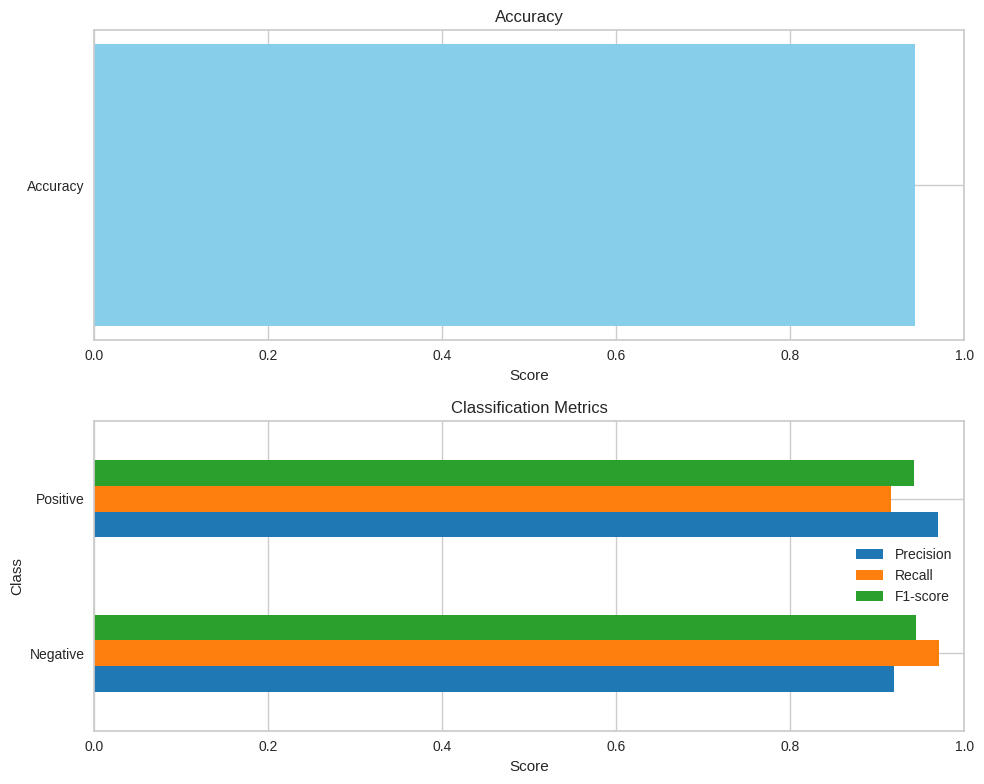

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
naive_bayes =MultinomialNB()
naive_bayes.fit(X_train,y_train)
y_pred=naive_bayes.predict(X_test)
report= classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print("naive bayes Classifier training score :",naive_bayes.score(X_train,y_train))
print("naive bayes Classifier testing score :",naive_bayes.score(X_test,y_test))

print(report)
naive_bayes_test_score =  round(naive_bayes.score(X_test, y_test) * 100, 2)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], output_dict=True)

# Extract the relevant metrics
accuracy = naive_bayes.score(X_test, y_test)
precision_negative = report['Negative']['precision']
recall_negative = report['Negative']['recall']
f1_negative = report['Negative']['f1-score']

precision_positive = report['Positive']['precision']
recall_positive = report['Positive']['recall']
f1_positive = report['Positive']['f1-score']

# Create a dataframe for better visualization
metrics_df = pd.DataFrame({
    'Class': ['Negative', 'Positive'],
    'Precision': [precision_negative, precision_positive],
    'Recall': [recall_negative, recall_positive],
    'F1-score': [f1_negative, f1_positive]
})

# Plotting the bar chart
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot accuracy separately
ax[0].barh(['Accuracy'], [accuracy], color='skyblue')
ax[0].set_xlim(0, 1)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Score')
ax[0].set_yticks(['Accuracy'])

# Plot precision, recall, and F1-score for each class
metrics_df.set_index('Class').plot(kind='barh', ax=ax[1], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[1].set_xlim(0, 1)
ax[1].set_title('Classification Metrics')
ax[1].set_xlabel('Score')

plt.tight_layout()
plt.show()


RF Classifier training score : 0.9995549621717846
RF Classifier testing score : 0.9395017793594306
              precision    recall  f1-score   support

    Negative       0.98      0.90      0.94       279
    Positive       0.91      0.98      0.94       283

    accuracy                           0.94       562
   macro avg       0.94      0.94      0.94       562
weighted avg       0.94      0.94      0.94       562



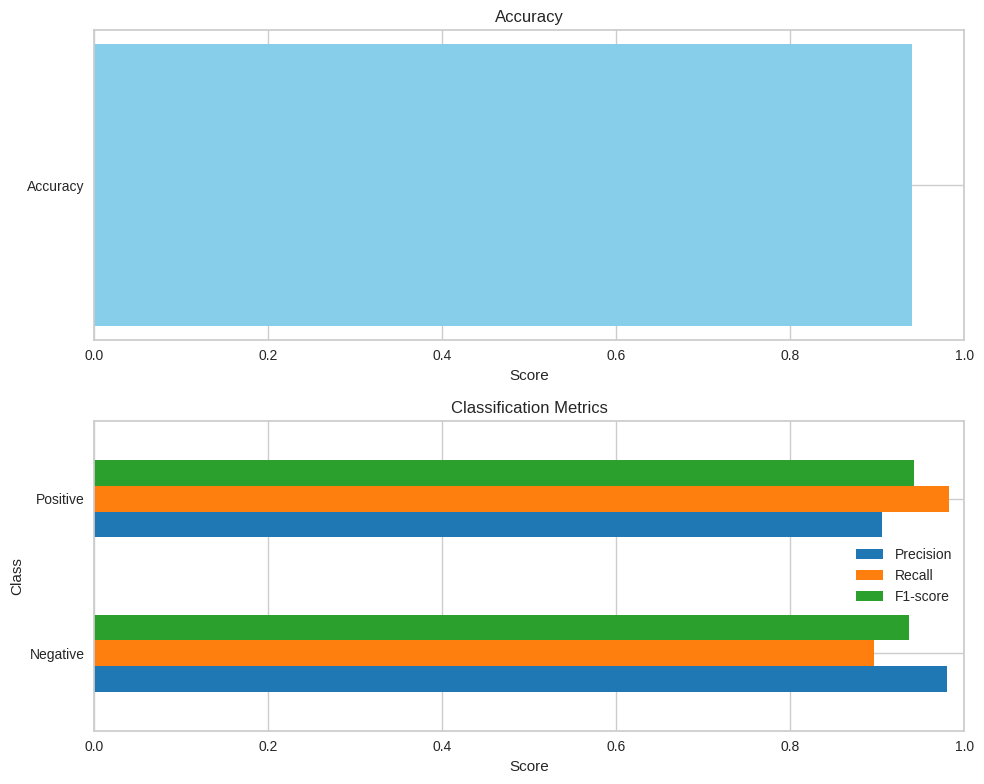

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(random_state=50)
RF.fit(X_train,y_train)

print("RF Classifier training score :",RF.score(X_train,y_train))
print("RF Classifier testing score :",RF.score(X_test,y_test))
y_pred = RF.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)

RF_test_score =  round(RF.score(X_test, y_test) * 100, 2)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], output_dict=True)

# Extract the relevant metrics
accuracy = RF.score(X_test, y_test)
precision_negative = report['Negative']['precision']
recall_negative = report['Negative']['recall']
f1_negative = report['Negative']['f1-score']

precision_positive = report['Positive']['precision']
recall_positive = report['Positive']['recall']
f1_positive = report['Positive']['f1-score']

# Create a dataframe for better visualization
metrics_df = pd.DataFrame({
    'Class': ['Negative', 'Positive'],
    'Precision': [precision_negative, precision_positive],
    'Recall': [recall_negative, recall_positive],
    'F1-score': [f1_negative, f1_positive]
})

# Plotting the bar chart
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot accuracy separately
ax[0].barh(['Accuracy'], [accuracy], color='skyblue')
ax[0].set_xlim(0, 1)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Score')
ax[0].set_yticks(['Accuracy'])

# Plot precision, recall, and F1-score for each class
metrics_df.set_index('Class').plot(kind='barh', ax=ax[1], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[1].set_xlim(0, 1)
ax[1].set_title('Classification Metrics')
ax[1].set_xlabel('Score')

plt.tight_layout()
plt.show()


LR Classifier training score : 0.9982198486871384
LR Classifier testing score : 0.9697508896797153
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97       279
    Positive       0.97      0.97      0.97       283

    accuracy                           0.97       562
   macro avg       0.97      0.97      0.97       562
weighted avg       0.97      0.97      0.97       562



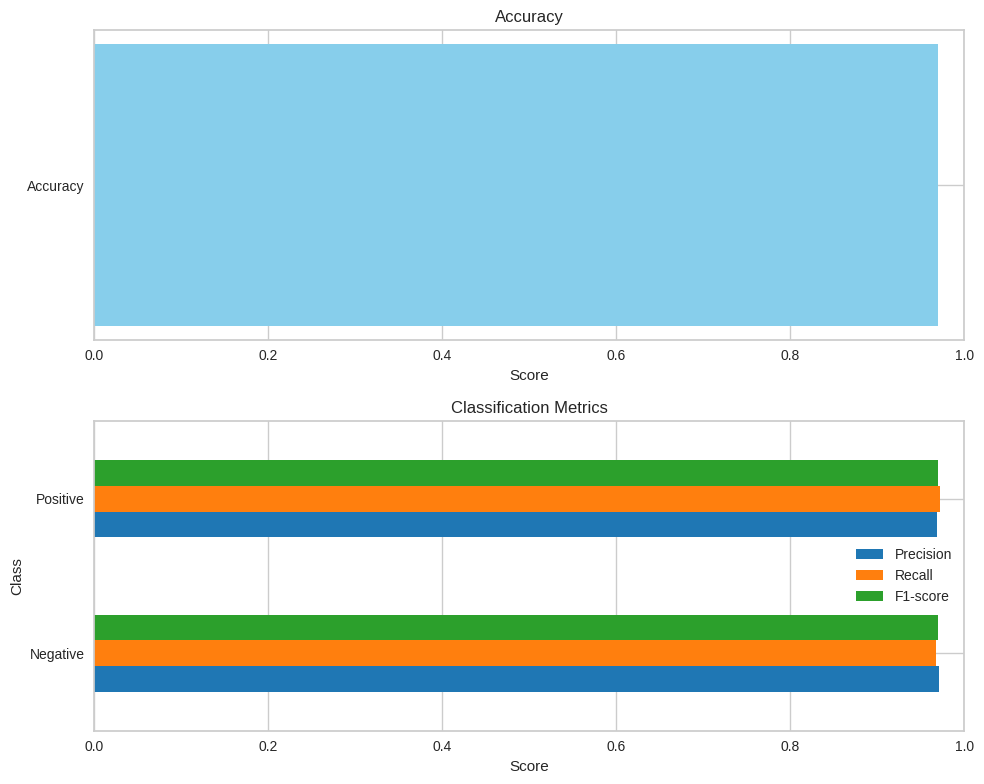

In [ ]:
from sklearn.linear_model import LogisticRegression

LR=LogisticRegression()
LR.fit(X_train,y_train)

print("LR Classifier training score :",LR.score(X_train,y_train))
print("LR Classifier testing score :",LR.score(X_test,y_test))
y_pred=LR.predict(X_test)
report=classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)
lR_test_score =  round(LR.score(X_test, y_test) * 100, 2)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], output_dict=True)

# Extract the relevant metrics
accuracy = LR.score(X_test, y_test)
precision_negative = report['Negative']['precision']
recall_negative = report['Negative']['recall']
f1_negative = report['Negative']['f1-score']

precision_positive = report['Positive']['precision']
recall_positive = report['Positive']['recall']
f1_positive = report['Positive']['f1-score']

# Create a dataframe for better visualization
metrics_df = pd.DataFrame({
    'Class': ['Negative', 'Positive'],
    'Precision': [precision_negative, precision_positive],
    'Recall': [recall_negative, recall_positive],
    'F1-score': [f1_negative, f1_positive]
})

# Plotting the bar chart
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot accuracy separately
ax[0].barh(['Accuracy'], [accuracy], color='skyblue')
ax[0].set_xlim(0, 1)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Score')
ax[0].set_yticks(['Accuracy'])

# Plot precision, recall, and F1-score for each class
metrics_df.set_index('Class').plot(kind='barh', ax=ax[1], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[1].set_xlim(0, 1)
ax[1].set_title('Classification Metrics')
ax[1].set_xlabel('Score')

plt.tight_layout()
plt.show()


In [ ]:
models = pd.DataFrame({
    'Model': ['Naive bayes', 'RandomForestClassifier', 'LogisticRegression'],
    'Score': [naive_bayes_test_score, RF_test_score,lR_test_score ]})

models = models.sort_values(by='Score', ascending=False)
models.style.background_gradient(cmap='Reds')

,Model,Score
2,LogisticRegression,96.980000
0,Naive bayes,94.310000
1,RandomForestClassifier,93.950000


In [ ]:
fig = go.Figure(go.Funnelarea(
    text =models.Model,
    values = models.Score,
    ))

fig.update_layout(
    title='<b>Distribution of score on testing data</b>',
    titlefont={'size': 20},
    paper_bgcolor='#E0E1CD',
    plot_bgcolor='#E0E1CD',
    showlegend=False
)

fig.show()

In [ ]:
naive_bayes_predicition = naive_bayes.predict(X_test)
RF_prediction = RF.predict(X_test)
LR_prediction = LR.predict(X_test)